# 2015 Nepal Earthquake Damage Prediction
- Link to data [here](http://eq2015.npc.gov.np/#/download)

## Contents<a class="anchor" id="contents"></a>
1. [Data Exploration](#data_exploration)
    1. [Initial Exploration](#initial_exploration)
        1. [Variable Dictionary](#variable_dictionary)
        2. [NaN Values](#nan_values)
        3. [Damage and Geography](#damage_and_geography)
        4. [Choropleth](#choropleth)
    2. [Categorical Features](#categorical_features)
        1. [land_surface_condition](#land_surface_condition)
        2. [foundation_type](#foundation_type)
        3. [roof_type](#roof_type)
        4. [ground_floor_type](#ground_floor_type)
        5. [other_floor_type](#other_floor_type)
        6. [position](#position)
        7. [plan_configuration](#plan_configuration)
    3. [Continuous Features](#continuous_features)
        1. [Capping](#capping)
        2. [count_floors_pre_eq](#count_floors_pre_eq)
        3. [height_ft_pre_eq](#height_ft_pre_eq)
        4. [age_building](#age_building)
        5. [plinth_area_sq_ft](#plinth_area_sq_ft)
    4. [Feature Engineering](#feature_engineering)
        1. [reinforced_concrete](#reinforced_concrete)
        2. [superstructure](#superstructure)
2. [Creating Data Files](#creating_data_files)
    1. [Dropping Columns](#dropping_columns)
    2. [Scaling](#scaling)
    3. [Splitting Up Data](#splitting_up_data)
4. [Regression Model](#regression_model)
    1. [Data Preparation](#data_preparation)
    2. [Multiple Linear Regression with EN Regularization](#multiple_linear_regression)
    3. [Model Performance](#model_performance)
4. [Classification Models](#classification_models)
    1. [Random Forest](#random_forest)
    2. [K-Nearest Neighbors](#knn)
    3. [Neural Network](#neural_network)
5. [Results](#results)

In [150]:
# basic imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib.font_manager import FontProperties
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.style.use('fivethirtyeight')

# map visualization
import censusdata as censusdata
import tabulate as tabulate
import geopandas as gpd
from geopandas import GeoDataFrame

# splitting data
from sklearn.model_selection import train_test_split

# cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV

# view parameters
from sklearn import set_config
set_config(print_changed_only=False)

# models
import joblib
from sklearn.cluster import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_regression

# model selection
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

In [2]:
# makes a table of average damage grade by each category
def make_table(xlabel, column):
    df = building.groupby(column).mean()['damage_grade'].reset_index()
    df['damage_grade'] = df['damage_grade'].round(3)
    df.sort_values(by = 'damage_grade', inplace=True)
    df.rename(columns={column:xlabel, 'damage_grade':'Average Damage Grade'}, inplace=True)
    if column == 'superstructure':
        df[xlabel] = ['neither/both', 'cement_mortar_brick', 'mud_mortar_stone']
    table = plt.table(cellText = df.values, colLabels = df.columns, loc='center', cellLoc='center')
    table.auto_set_column_width(col=list(range(len(df.columns))))
    table.scale(1, 2)
    # bold column headings
    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    plt.axis('off')
    
# makes a stacked bar chart of proportions by damage grade, change the categorical x variable
def make_stacked_bar(xlabel, column):
    pivot_df = building.pivot_table(index = [column], columns = ['damage_grade'], 
                                    values = ['building_id'], aggfunc = np.size) 
    pivot_df.fillna(0, inplace=True)
    totals = pivot_df['building_id'][0] + pivot_df['building_id'][1] + pivot_df['building_id'][2]
    pivot_df_proportions = pd.DataFrame({'0':pivot_df['building_id'][0]/totals,
                                         '1':pivot_df['building_id'][1]/totals,
                                         '2':pivot_df['building_id'][2]/totals})
    pivot_df_proportions.reset_index(inplace=True)
    pivot_df_proportions.sort_values(by = '0', inplace=True, ascending=False)
    pivot_df_proportions.plot(x=column, kind='bar', stacked=True)
    plt.title('Proportion of Damage Grades by {}'.format(xlabel))
    if not isinstance(pivot_df_proportions[column][0], str): # rotate ticks to horizontal if numerical category name
        plt.xticks(rotation='horizontal')
    plt.xlabel(xlabel)
    plt.ylabel('Proportion')
    plt.legend(['0:Low', '1:Medium', '2:High'], fancybox=True, title='Damage Grade', 
               loc = 'center left', bbox_to_anchor =(1, 0.5));

# construct both and saves to png
def make_plots(xlabel, column, directory):
    make_table(xlabel, column)
    plt.savefig('figures/{}_table.png'.format(directory), bbox_inches = 'tight', transparent = True)
    make_stacked_bar(xlabel, column)
    plt.savefig('figures/{}.png'.format(directory), bbox_inches = 'tight', transparent = True)

# 1) Data Exploration <a class="anchor" id="data_exploration"></a>
[To contents](#contents)

In [3]:
structure = pd.read_csv('data/csv_building_structure.csv')

In [4]:
# map district_id to district_name
district_mapping = pd.read_csv('data/ward_district_name_mapping.csv').groupby('district_name').mean().reset_index()
district_mapping['district_id'] = district_mapping['district_id'].apply(lambda x : int(x))
district_mapping.drop(columns=['ward_id', 'vdcmun_id'], inplace=True)

building = district_mapping.merge(structure, on = 'district_id', how = 'right')
building.head()

,district_name,district_id,building_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
0,Okhaldhunga,12,120101000011,1207,120703,1,1,9,288,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
1,Okhaldhunga,12,120101000021,1207,120703,1,1,15,364,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
2,Okhaldhunga,12,120101000031,1207,120703,1,1,20,384,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
3,Okhaldhunga,12,120101000041,1207,120703,1,1,20,312,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
4,Okhaldhunga,12,120101000051,1207,120703,1,1,30,308,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair


In [5]:
print(building.shape)

(762106, 32)


## A) Initial Exploration<a class="anchor" id="initial_exploration"></a>
[To contents](#contents)

### a) Variable Dictionary <a class="anchor" id="variable_dictionary"></a>
[To contents](#contents)
- **district_name** (str) - District where the building is located
- **district_id** (int) - District where the building is located
- **building_id** (int) - A unique ID that identifies a unique building from the survey
- **vdcmun_id** (int) - Municipality where the building is located
- **ward_id** (int) - Ward Number in which the building is located
- **count_floors_pre_eq** (int) - Number of floors that the building had before the earthquake
- **count_floors_post_eq** (int) - Number of floors that the building had after the earthquake
- **age_building** (int) - Age of the building (in years)
- **plinth_area_sq_ft** (int) - Plinth area of the building (in square feet)
- **height_ft_pre_eq** (int) - Height of the building before the earthquake (in feet)
- **height_ft_post_eq** (int) - Height of the building after the earthquake (in feet)
- **land_surface_condition** (int) - Surface condition of the land in which the building is built
- **foundation_type** (str) - Type of foundation used in the building
- **roof_type** (str) - Type of roof used in the building
- **ground_floor_type** (str) - Ground floor type
- **other_floor_type** (str) - Type of construction used in other floors (except ground floor and roof)	
- **position** (str) - Position of the building
- **plan_configuration** (str) - Building plan configuration
- **has_superstructure_adobe_mud** (int) - Flag variable that indicates if the superstructure of the building is made of Adobe/Mud
- **has_superstructure_mud_mortar_stone** (int) - Flag variable that indicates if the superstructure of the building is made of Mud Mortar - Stone
- **has_superstructure_stone_flag** (int) - Flag variable that indicates if the superstructure of the building is made of Stone
- **has_superstructure_cement_mortar_stone** (int) - Flag variable that indicates if the superstructure of the building is made of Stone
- **has_superstructure_mud_mortar_brick** (int) - Flag variable that indicates if the superstructure of the building is made of Cement Mortar - Stone
- **has_superstructure_cement_mortar_brick** (int) - Flag variable that indicates if the superstructure of the building is made of Mud Mortar - Brick
- **has_superstructure_timber** (int) - Flag variable that indicates if the superstructure of the building is made of Timber
- **has_superstructure_bamboo** (int) - Flag variable that indicates if the superstructure of the building is made of Bamboo
- **has_superstructure_rc_non_engineered** (int) - Flag variable that indicates if the superstructure of the building is made of RC (Non Engineered)
- **has_superstructure_rc_engineered** (int) - Flag variable that indicates if the superstructure of the building is made of RC (Engineered)
- **has_superstructure_other** (int) - Flag variable that indicates if the superstructure of the building is made of any other material
- **condition_post_eq** (str) - Actual contition of the building after the earthquake
- **damage_grade** (str) - Damage grade assigned to the building by the surveyor after assessment
- **technical_solution_proposed** (str) - Technical solution proposed by the surveyor after assessment

### b) NaN Values<a class="anchor" id="nan_values"></a>
[To contents](#contents)

In [6]:
null = building.isnull().sum()
for i in range(len(null)):
    if null[i] > 0:
        print(building.columns[i],':', null[i])

position : 1
plan_configuration : 1
damage_grade : 12
technical_solution_proposed : 12


- There are four features with null values: `position`, `plan_configuration`, `damage_grade`, `damage_grade_3`
- Drop `damage_grade` rows with null values since that is the variable we are trying to predict
- This took care of all other null values!

In [7]:
building = building.dropna(subset=['damage_grade'])
sum(building.isnull().sum() > 0)

0

### c) Damage and Geography <a class="anchor" id="damage_and_geography"></a>
[To contents](#contents)

- Map `damage_grade` to three classes: high (2), medium (1), low(0)
    - High is Grade 4 + Grade 5
    - Medium is Grade 3
    - Low is Grade 2 + Grade 1

In [8]:
# transform to numerical
building["damage_grade"]=building['damage_grade'].map({'Grade 5':2,'Grade 4':2,'Grade 3':1, 'Grade 2':0, 'Grade 1':0})

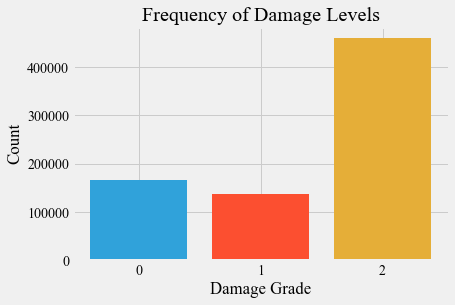

In [9]:
building_damage = building.groupby('damage_grade').count().reset_index()
plt.bar(building_damage['damage_grade'], building_damage['building_id'],
        color=['#30a2da', '#fc4f30', '#e5ae38'])
plt.title('Frequency of Damage Levels')
plt.xlabel('Damage Grade')
plt.xticks([0, 1, 2])
plt.ylabel('Count');

plt.savefig('figures/damage/frequency.png', bbox_inches = 'tight', transparent = True)

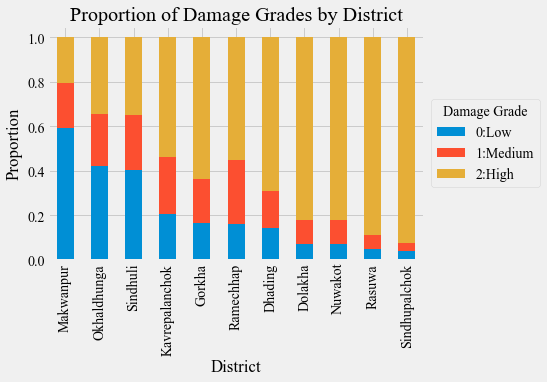

In [10]:
# damage by region
make_stacked_bar('District', 'district_name')
plt.savefig('figures/damage/frequency_district.png', bbox_inches = 'tight', transparent = True)

- Data is skewed, since there are more than double the amount of rows with damage grade 2 than damage grade 1
- We will use accuracy, precision, and recall to give a better understanding of performance in the model
- Accuracy = (true positive + true negative)/total
- Precision = true positive/(true positive + false positive)
- Recall = true positive/(true positive + false negative)

### d) Choropleth <a class="anchor" id="choropleth"></a>
[To contents](#contents)

In [11]:
# average damage grade by district
average_damage_districts = building.groupby('district_name').agg({'damage_grade':['mean']})
average_damage_districts.columns = average_damage_districts.columns.droplevel()
average_damage_districts

,mean
district_name,
Dhading,1.549225
Dolakha,1.749138
Gorkha,1.470771
Kavrepalanchok,1.334394
Makwanpur,0.616667
Nuwakot,1.754640
Okhaldhunga,0.923765
Ramechhap,1.394680
Rasuwa,1.840082


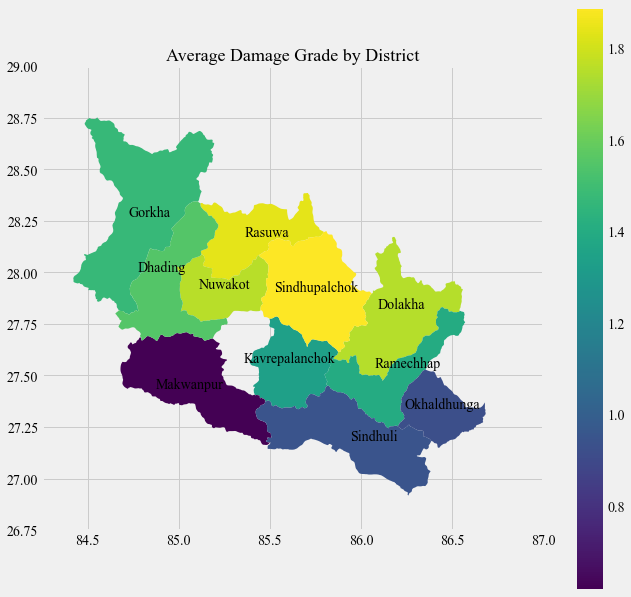

In [12]:
nepal_districts_map = gpd.read_file('geopandas_map/shape_files_of_districts_in_nepal.shp')
damage_districts_map = pd.merge(average_damage_districts, nepal_districts_map, 
                                left_on='district_name', right_on='dist_name', how='right')
damage_districts_map = GeoDataFrame(damage_districts_map)

def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]
# just plotting the 11 affected districts:
list_dists_plot = list(average_damage_districts.index.values)
filtered_map = damage_districts_map.copy()
filtered_map = filtered_map.loc[filtered_map['dist_name'].isin(list_dists_plot)==True]
ax = filtered_map.plot(column='mean', figsize=(10,10), legend=True)
ax.set_xlim(84.25, 87)
ax.set_ylim(26.75, 29)
# damage_districts_map.plot(column='dist_name')
plt.title('Average Damage Grade by District', fontsize=18)
# add labels
filtered_map['coords'] = filtered_map['geometry'].apply(lambda x: x.representative_point().coords[:])
filtered_map['coords'] = [coords[0] for coords in filtered_map['coords']]
for idx, row in filtered_map.iterrows():
    plt.annotate(s=row['dist_name'], xy=row['coords'],horizontalalignment='center')
plt.savefig('figures/damage/choropleth.png', bbox_inches = 'tight', transparent = True)

## B) Categorical Features <a class="anchor" id="categorical_features"></a>
[To contents](#contents)
- Includes `land_surface_condition`, `foundation_type`, `roof_type`, `ground_floor_type`, `other_floor_type`, `position`, and `plan_configuration`

In [13]:
# explore the number of unique values for each feature
for col in ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 
            'position', 'plan_configuration']:
    print('{}: {} unique values'.format(col, building[col].nunique()))

land_surface_condition: 3 unique values
foundation_type: 5 unique values
roof_type: 3 unique values
ground_floor_type: 5 unique values
other_floor_type: 4 unique values
position: 4 unique values
plan_configuration: 10 unique values


### a) land_surface_condition <a class="anchor" id="land_surface_condition"></a>
[To contents](#contents)

In [14]:
building.groupby('land_surface_condition').count()['district_name'].reset_index()

,land_surface_condition,district_name
0,Flat,631663
1,Moderate slope,105640
2,Steep slope,24791


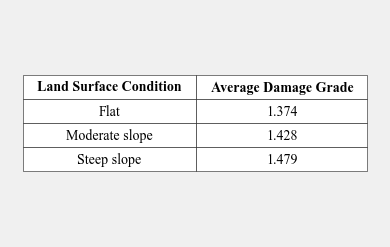

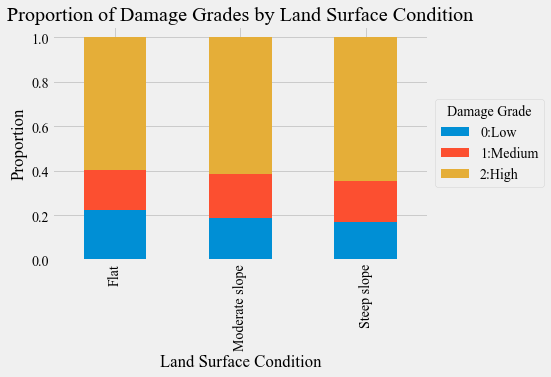

In [15]:
make_plots('Land Surface Condition', 'land_surface_condition', 'categorical/land_surface_condition')

In [16]:
# transform to numerical
building["land_surface_condition"]=building['land_surface_condition'].map({'Flat':0,'Moderate slope':1,'Steep slope':2})

### b) foundation_type <a class="anchor" id="foundation_type"></a>
[To contents](#contents)

In [17]:
building.groupby('foundation_type').count()['district_name'].reset_index()

,foundation_type,district_name
0,Bamboo/Timber,57472
1,Cement-Stone/Brick,39245
2,Mud mortar-Stone/Brick,628705
3,Other,4552
4,RC,32120


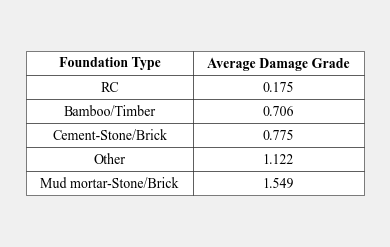

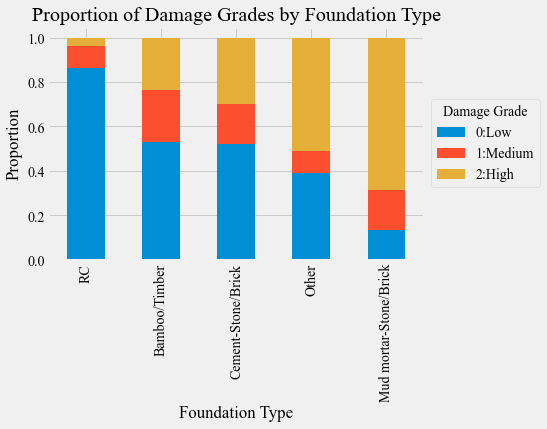

In [18]:
make_plots('Foundation Type', 'foundation_type', 'categorical/foundation_type')

In [19]:
# transform to numerical
building["foundation_type"]=building['foundation_type'].map({'RC':0,'Bamboo/Timber':1,'Cement-Stone/Brick':2,
                                                             'Mud mortar-Stone/Brick':3,'Other':4})

### c) roof_type <a class="anchor" id="roof_type"></a>
[To contents](#contents)

In [20]:
building.groupby('roof_type').count()['district_name'].reset_index()

,roof_type,district_name
0,Bamboo/Timber-Heavy roof,213774
1,Bamboo/Timber-Light roof,503736
2,RCC/RB/RBC,44584


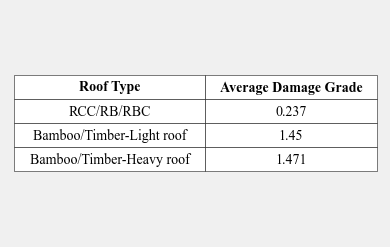

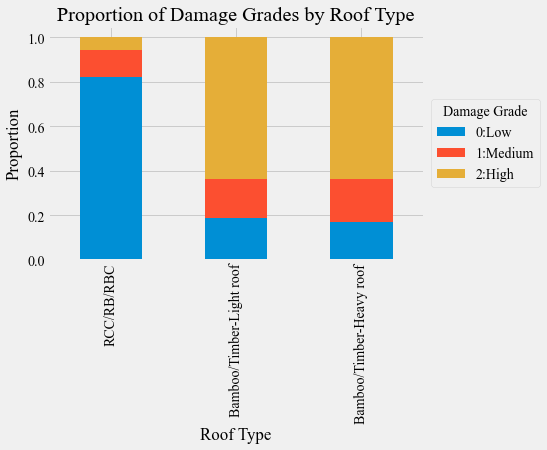

In [21]:
make_plots('Roof Type', 'roof_type', 'categorical/roof_type')

In [22]:
# transform to numerical
building["roof_type"]=building['roof_type'].map({'RCC/RB/RBC':0,'Bamboo/Timber-Heavy roof':1,'Bamboo/Timber-Light roof':1})

### d) ground_floor_type <a class="anchor" id="ground_floor_type"></a>
[To contents](#contents)

In [23]:
building.groupby('ground_floor_type').count()['district_name'].reset_index()

,ground_floor_type,district_name
0,Brick/Stone,66093
1,Mud,618205
2,Other,1053
3,RC,73149
4,Timber,3594


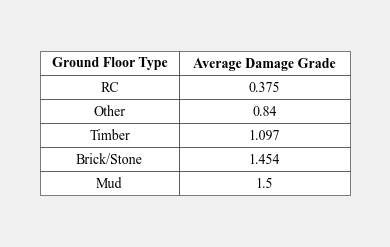

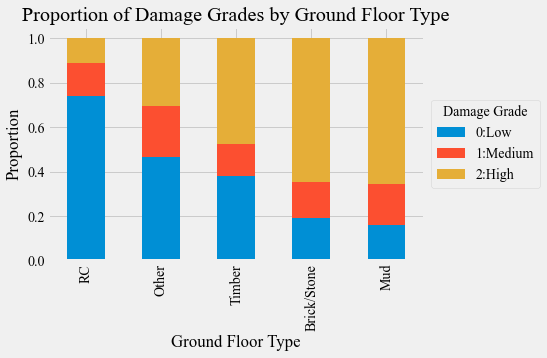

In [24]:
make_plots('Ground Floor Type', 'ground_floor_type', 'categorical/ground_floor_type')

In [25]:
# transform to numerical
building["ground_floor_type"]=building['ground_floor_type'].map({'RC':0,'Brick/Stone':1,'Mud':2,'Timber':3,'Other':4})

### e) other_floor_type <a class="anchor" id="other_floor_type"></a>
[To contents](#contents)

In [26]:
building.groupby('other_floor_type').count()['district_name'].reset_index()

,other_floor_type,district_name
0,Not applicable,118821
1,RCC/RB/RBC,32742
2,TImber/Bamboo-Mud,486907
3,Timber-Planck,123624


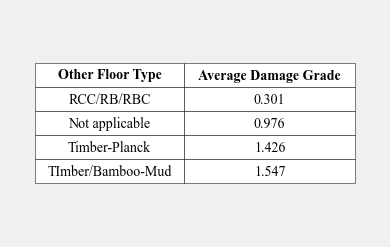

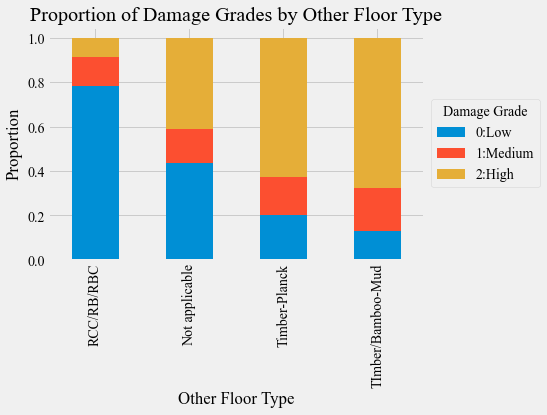

In [27]:
make_plots('Other Floor Type', 'other_floor_type', 'categorical/other_floor_type')

In [28]:
# transform to numerical
building["other_floor_type"]=building['other_floor_type'].map({'RCC/RB/RBC':0,'TImber/Bamboo-Mud':1,
                                                               'Timber-Planck':2,'Not applicable':3})

### f) position <a class="anchor" id="position"></a>
[To contents](#contents)

In [29]:
building.groupby('position').count()['district_name'].reset_index()

,position,district_name
0,Attached-1 side,129431
1,Attached-2 side,26910
2,Attached-3 side,1310
3,Not attached,604443


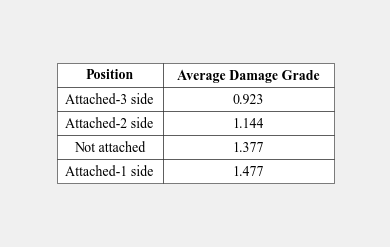

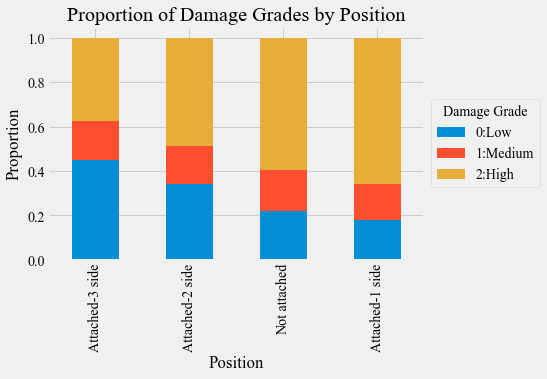

In [30]:
make_plots('Position', 'position', 'categorical/position')

In [31]:
# transform to numerical
building["position"]=building['position'].map({'Not attached':0,'Attached-1 side':1,
                                               'Attached-2 side':2,'Attached-3 side':3})

### g) plan_configuration <a class="anchor" id="plan_configuration"></a>
[To contents](#contents)

In [32]:
building.groupby('plan_configuration').count()['district_name'].reset_index()

,plan_configuration,district_name
0,Building with Central Courtyard,98
1,E-shape,140
2,H-shape,80
3,L-shape,10079
4,Multi-projected,940
5,Others,518
6,Rectangular,731246
7,Square,17576
8,T-shape,969
9,U-shape,448


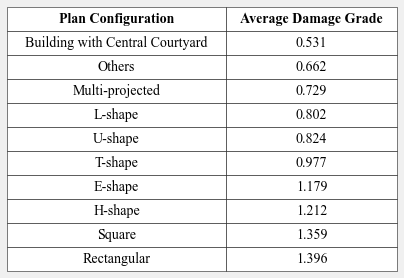

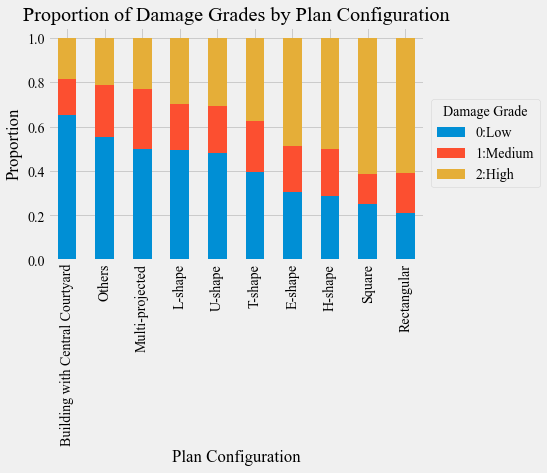

In [33]:
make_plots('Plan Configuration', 'plan_configuration', 'categorical/plan_configuration')

In [34]:
# transform to numerical
building['plan_configuration']=building['plan_configuration'].map({'Building with Central Courtyard':0, 
                                                                   'E-shape':1, 'H-shape':2, 'L-shape':3,
                                                                   'Multi-projected':4, 'Others':5, 'Rectangular':6, 
                                                                   'Square':7, 'T-shape':8,'U-shape':9})

## C) Continuous Features<a class="anchor" id="continuous_features"></a>
[To contents](#contents)
- Includes `count_floors_pre_eq`, `height_ft_pre_eq`, `age_building`, and `plinth_area_sq_ft`

In [35]:
cont_features = ['count_floors_pre_eq', 'height_ft_pre_eq', 'age_building', 'plinth_area_sq_ft']
building_cont = building[cont_features]
building_cont.describe()

,count_floors_pre_eq,height_ft_pre_eq,age_building,plinth_area_sq_ft
count,762094.000000,762094.000000,762094.000000,762094.000000
mean,2.087787,16.049424,24.325031,406.673668
std,0.655104,5.493900,65.034555,226.780437
min,1.000000,6.000000,0.000000,70.000000
25%,2.000000,12.000000,9.000000,280.000000
50%,2.000000,16.000000,16.000000,358.000000
75%,2.000000,18.000000,27.000000,470.000000
max,9.000000,99.000000,999.000000,5000.000000


### a) Capping<a class="anchor" id="capping"></a>
[To contents](#contents)
- Detect outliers in continuous features and remove them
- Check for >95%, >97.5%, >99.5%, 3sd

In [36]:
# see where outliers might be an issue
print(building[['count_floors_pre_eq','height_ft_pre_eq','age_building','plinth_area_sq_ft']].describe().loc['max'])

count_floors_pre_eq       9.0
height_ft_pre_eq         99.0
age_building            999.0
plinth_area_sq_ft      5000.0
Name: max, dtype: float64


In [37]:
# given a feature, detect outliers and store them
def detect_outlier(feature):
    outliers = []
    data = building[feature]
    mean = np.mean(data)
    std = np.std(data)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {}%'.format(data.quantile(.95), round(100*np.mean(data > data.quantile(.95)), 4)))
    print('  --97p: {:.1f} / {}%'.format(data.quantile(.97), round(100*np.mean(data > data.quantile(.97)), 4)))    
    print('  --99p: {:.1f} / {}%'.format(data.quantile(.99), round(100*np.mean(data > data.quantile(.99)), 4)))
    print('  --3sd: {:.1f} / {}%'.format(mean + 3*(std), round(100*np.mean(data > mean + 3*(std)),4 )))

In [38]:
# determine what the upperbound should be for continuous features
for feat in ['count_floors_pre_eq','height_ft_pre_eq','age_building','plinth_area_sq_ft']:
    detect_outlier(feat)


Outlier caps for count_floors_pre_eq:
  --95p: 3.0 / 1.0627%
  --97p: 3.0 / 1.0627%
  --99p: 4.0 / 0.2643%
  --3sd: 4.1 / 0.2643%

Outlier caps for height_ft_pre_eq:
  --95p: 24.0 / 4.9071%
  --97p: 27.0 / 2.1951%
  --99p: 32.0 / 0.8982%
  --3sd: 32.5 / 0.8982%

Outlier caps for age_building:
  --95p: 54.0 / 4.9922%
  --97p: 65.0 / 2.9175%
  --99p: 90.0 / 0.9566%
  --3sd: 219.4 / 0.4125%

Outlier caps for plinth_area_sq_ft:
  --95p: 800.0 / 4.7141%
  --97p: 912.0 / 2.9701%
  --99p: 1222.0 / 0.999%
  --3sd: 1087.0 / 1.5984%


In [39]:
# cap features at 99%
building['count_floors_pre_eq'] = building['count_floors_pre_eq'].clip(upper=building['count_floors_pre_eq'].quantile(.99))
building['height_ft_pre_eq'] = building['height_ft_pre_eq'].clip(upper=building['height_ft_pre_eq'].quantile(.99))
building['age_building'] = building['age_building'].clip(upper=building['age_building'].quantile(.99))
building['plinth_area_sq_ft'] = building['plinth_area_sq_ft'].clip(upper=building['plinth_area_sq_ft'].quantile(.99))\

# check cap
print(building[['count_floors_pre_eq','height_ft_pre_eq','age_building','plinth_area_sq_ft']].describe().loc['max'])

count_floors_pre_eq       4.0
height_ft_pre_eq         32.0
age_building             90.0
plinth_area_sq_ft      1222.0
Name: max, dtype: float64


### b) count_floors_pre_eq<a class="anchor" id="count_floors_pre_eq"></a>
[To contents](#contents)

In [40]:
building.groupby('damage_grade').mean()['count_floors_pre_eq'].reset_index()

,damage_grade,count_floors_pre_eq
0,0,1.849168
1,1,2.058990
2,2,2.176876


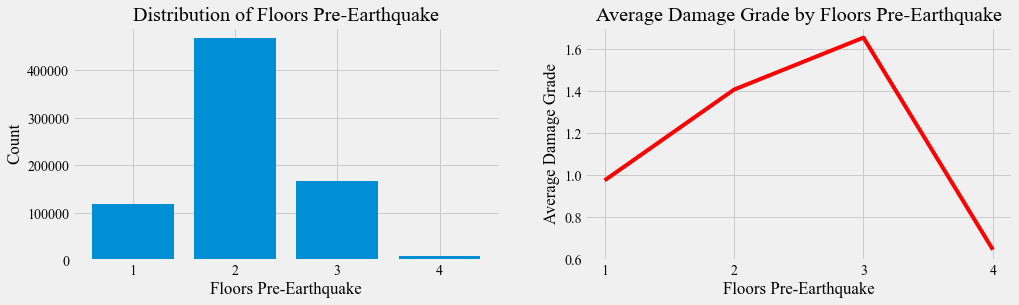

In [41]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(building['count_floors_pre_eq'], align="mid", rwidth=0.8,
         bins=np.arange(min(building['count_floors_pre_eq']), 6, 1)-0.5)
plt.title('Distribution of Floors Pre-Earthquake')
plt.xticks([1,2,3,4])
plt.xlabel('Floors Pre-Earthquake')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
floors = building.groupby('count_floors_pre_eq').mean()
plt.plot(floors.index, floors['damage_grade'], color = 'red')
plt.title('Average Damage Grade by Floors Pre-Earthquake')
plt.xticks([1,2,3,4])
plt.xlabel('Floors Pre-Earthquake')
plt.ylabel('Average Damage Grade');

plt.savefig('figures/continuous/count_floors_pre_eq.png', bbox_inches = 'tight', transparent = True)

### c) height_ft_pre_eq<a class="anchor" id="height_ft_pre_eq"></a>
[To contents](#contents)

In [42]:
building.groupby('damage_grade').mean()['height_ft_pre_eq'].reset_index()

,damage_grade,height_ft_pre_eq
0,0,15.165422
1,1,16.044314
2,2,16.205733


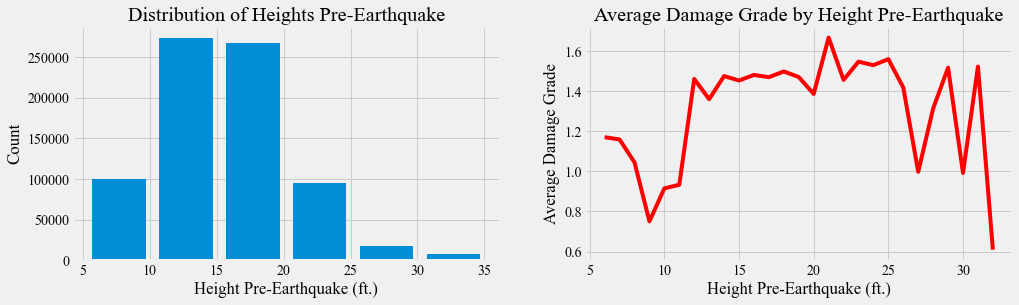

In [43]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(building['height_ft_pre_eq'], align="mid", rwidth=0.8,
         bins=np.arange(min(building['height_ft_pre_eq']), 35+5, 5)-0.8);
plt.title('Distribution of Heights Pre-Earthquake')
plt.xlabel('Height Pre-Earthquake (ft.)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
height = building.groupby('height_ft_pre_eq').mean()
plt.plot(height.index, height['damage_grade'], color = 'red')
plt.title('Average Damage Grade by Height Pre-Earthquake')
plt.xlabel('Height Pre-Earthquake (ft.)')
plt.ylabel('Average Damage Grade');

plt.savefig('figures/continuous/height_ft_pre_eq.png', bbox_inches = 'tight', transparent = True)

### d) age_building <a class="anchor" id="age_building"></a>
[To contents](#contents)

In [44]:
building.groupby('damage_grade').mean()['age_building'].reset_index()

,damage_grade,age_building
0,0,13.34317
1,1,20.66522
2,2,22.95434


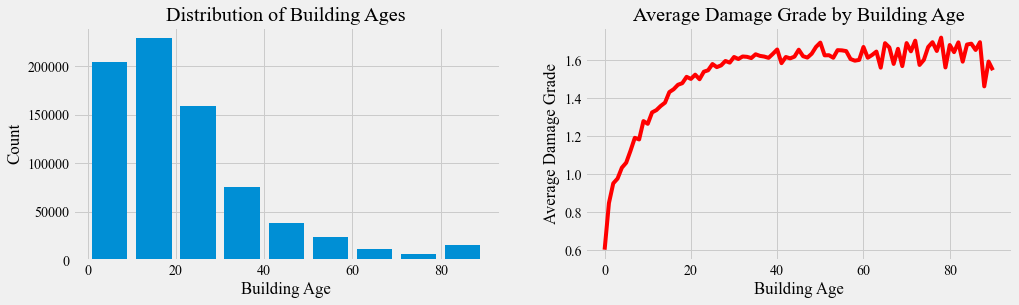

In [45]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(building['age_building'], align="mid", rwidth=0.8,
         bins=np.arange(min(building['age_building']), 90+10, 10));
plt.title('Distribution of Building Ages')
plt.xlabel('Building Age')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
age = building.groupby('age_building').mean()
plt.plot(age.index, age['damage_grade'], color = 'red')
plt.title('Average Damage Grade by Building Age')
plt.xlabel('Building Age')
plt.ylabel('Average Damage Grade');

plt.savefig('figures/continuous/age_building.png', bbox_inches = 'tight', transparent = True)

### e) plinth_area_sq_ft <a class="anchor" id="plinth_area_sq_ft"></a>
[To contents](#contents)

In [46]:
building.groupby('damage_grade').mean()['plinth_area_sq_ft'].reset_index()

,damage_grade,plinth_area_sq_ft
0,0,463.345145
1,1,403.984232
2,2,379.341709


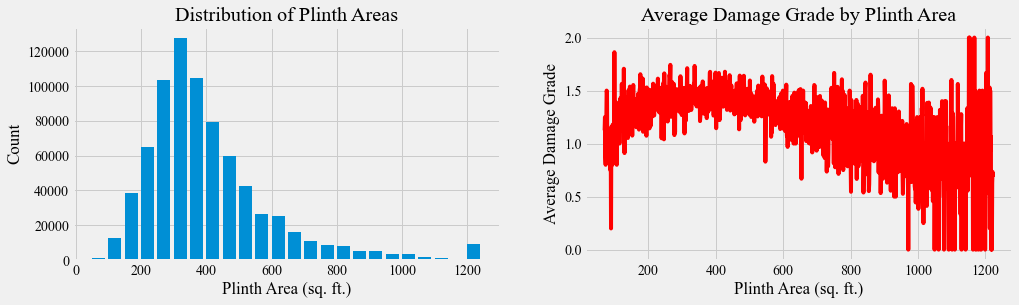

In [47]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(building['plinth_area_sq_ft'], align="mid", rwidth=0.8,
         bins=np.arange(min(building['plinth_area_sq_ft']), 1250+50, 50)-25);
plt.title('Distribution of Plinth Areas')
plt.xlabel('Plinth Area (sq. ft.)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
area = building.groupby('plinth_area_sq_ft').mean()
plt.plot(area.index, area['damage_grade'], color = 'red')
plt.title('Average Damage Grade by Plinth Area')
plt.xlabel('Plinth Area (sq. ft.)')
plt.ylabel('Average Damage Grade');

plt.savefig('figures/continuous/plinth_area_sq_ft.png', bbox_inches = 'tight', transparent = True)

## D) Feature Engineering  <a class="anchor" id="feature_engineering"></a>
[To contents](#contents)

### a) reinforced_concrete <a class="anchor" id="reinforced_concrete"></a>
[To contents](#contents)
- Possible components are `foundation_type`, `roof_type`, `ground_floor_type`, `other_floor_type`, `has_superstructure_rc_engineered`, and `has_superstructure_rc_non_engineered`
- New column `num_reinforced_concrete` with number of reinforced concrete components, value will be between 0 and 6
- New column `reinforced_concrete` with 1 for at least 1 reinforced concrete component, 0 for no reinforced concrete components

In [48]:
foundation_type = 0+(building['foundation_type'] == 0)
roof_type = 0+(building['roof_type'] == 0)
ground_floor_type = 0+(building['ground_floor_type'] == 0)
other_floor_type = 0+(building['other_floor_type'] == 0)
rc_non_engineered = 0+(building['has_superstructure_rc_non_engineered'] == 1)
rc_engineered = 0+(building['has_superstructure_rc_engineered'] == 1)

reinforced_concrete = foundation_type + roof_type + ground_floor_type + other_floor_type + rc_non_engineered + rc_engineered
building['num_reinforced_concrete'] = reinforced_concrete
building['reinforced_concrete'] = 0+(reinforced_concrete > 0)

In [49]:
building.groupby('num_reinforced_concrete').count()['district_name'].reset_index()

,num_reinforced_concrete,district_name
0,0,673466
1,1,40056
2,2,9257
3,3,8462
4,4,13022
5,5,17620
6,6,211


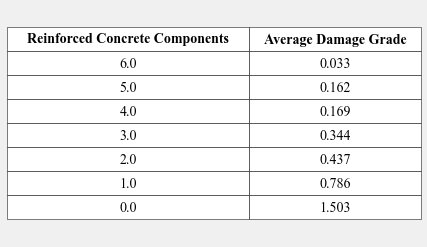

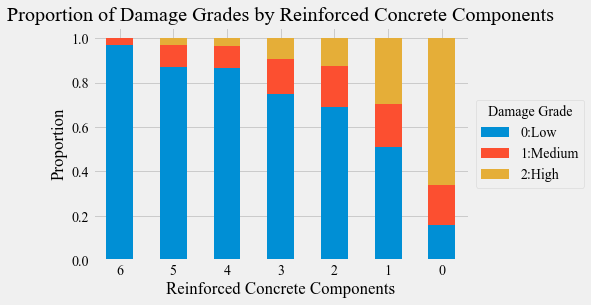

In [50]:
make_plots('Reinforced Concrete Components', 'num_reinforced_concrete', 'feature_engineering/num_reinforced_concrete')

In [51]:
building.groupby('reinforced_concrete').count()['district_name'].reset_index()

,reinforced_concrete,district_name
0,0,673466
1,1,88628


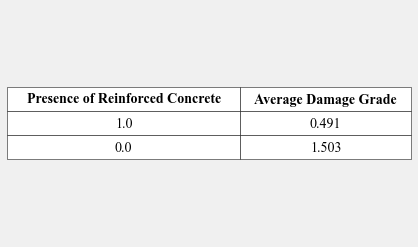

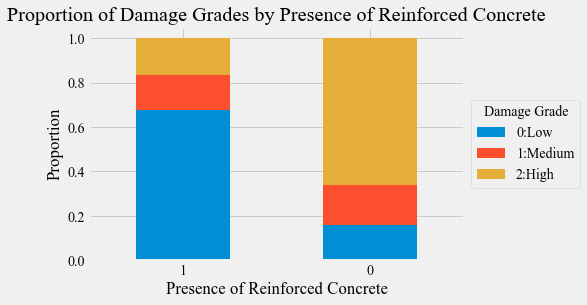

In [52]:
make_plots('Presence of Reinforced Concrete', 'reinforced_concrete', 'feature_engineering/reinforced_concrete')

In [53]:
# proportion of buildings with reinforced concrete
building.groupby('reinforced_concrete').count()['district_name'][1]/building.shape[0]

0.11629536513868367

- `reinforced_concrete` is a good predictor due to the fact that all buildings with some sort of reinforced concrete are better at surviving damage, and that the imbalance is not too great (11.6% of buildings have reinforced concrete)
- `num_reinforced_concrete` is too imbalanced, so prefer `reinforced_concrete`

### b) superstructure <a class="anchor" id="superstructure"></a>
[To contents](#contents)
- `superstructure_damage_1`: average damage rating for buildings with this material
- `superstructure_damage_0`: average damage rating for buildings with this material
- `frequency_1`: frequency of buildings with this value
- `superstructure_damage_diff`: difference in average damage between buildings with and without this material

In [54]:
superstructure_columns = building.loc[:,'has_superstructure_adobe_mud':'has_superstructure_other'].columns
superstructure = pd.DataFrame(index = superstructure_columns, 
                              columns = ['superstructure_damage_1', 'superstructure_damage_0', 'frequency_1'])
for i in superstructure.index:
    superstructure.loc[i, 'superstructure_damage_1'] = building[building[i] == 1]['damage_grade'].mean()
    s = building[building[i] == 1].drop(columns=['damage_grade']).T.sum()
    index = s[s==1].index
    superstructure.loc[i, 'superstructure_damage_0'] = building[building[i] == 0]['damage_grade'].mean()
    superstructure.loc[i, 'frequency_1'] = len(building[building[i] == 1])/len(building)

superstructure['superstructure_damage_diff'] = superstructure['superstructure_damage_1'] - superstructure['superstructure_damage_0']
superstructure

,superstructure_damage_1,superstructure_damage_0,frequency_1,superstructure_damage_diff
has_superstructure_adobe_mud,1.438107,1.382829,0.042402,0.055278
has_superstructure_mud_mortar_stone,1.576076,0.620278,0.800269,0.955798
has_superstructure_stone_flag,1.617948,1.3767,0.035122,0.241248
has_superstructure_cement_mortar_stone,0.975525,1.391756,0.015816,-0.416231
has_superstructure_mud_mortar_brick,1.261215,1.388086,0.022962,-0.126871
has_superstructure_cement_mortar_brick,0.35577,1.464475,0.071527,-1.108705
has_superstructure_timber,1.241021,1.435498,0.25877,-0.194477
has_superstructure_bamboo,1.094349,1.410628,0.080484,-0.316279
has_superstructure_rc_non_engineered,0.545422,1.419975,0.039794,-0.874554
has_superstructure_rc_engineered,0.11443,1.406343,0.016386,-1.291913


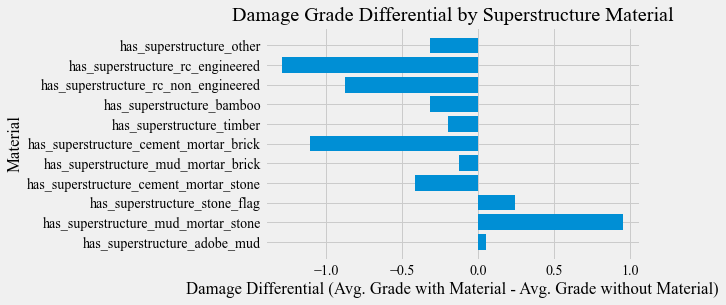

In [55]:
# damage differential for each material
plt.barh(superstructure.index, superstructure['superstructure_damage_diff']);
plt.title('Damage Grade Differential by Superstructure Material')
plt.xlabel('Damage Differential (Avg. Grade with Material - Avg. Grade without Material)')
plt.ylabel('Material');

plt.savefig('figures/feature_engineering/superstructure_comparison.png', bbox_inches = 'tight', transparent = True)

- Two impactful and relatively common material are `has_superstructure_cement_mortar_brick` (7.15%) and `has_superstructure_mud_mortar_stone` (80.03%)
- Combine these two columns
    - 1 if `has_superstructure_cement_mortar_brick`
    - 2 if `has_superstructure_mud_mortar_stone`
    - 0 if neither or both (since they are oppositely correlated with building damage)
- Two other columns which are highly impactful, `has_superstructure_rc_non_engineered` and `has_superstructure_rc_engineered`, were already considered in [section a)](#reinforced_concrete)

In [56]:
# combine has_superstructure_cement_mortar_brick and has_superstructure_mud_mortar_stone
building['superstructure'] = (building['has_superstructure_cement_mortar_brick'] + 
                              2*building['has_superstructure_mud_mortar_stone'])%3
building.groupby('superstructure').mean()['damage_grade']

superstructure
0    0.786251
1    0.313733
2    1.578430
Name: damage_grade, dtype: float64

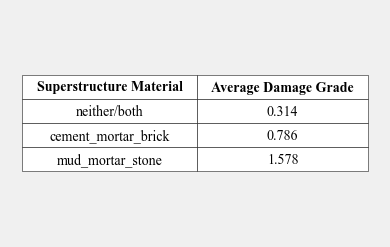

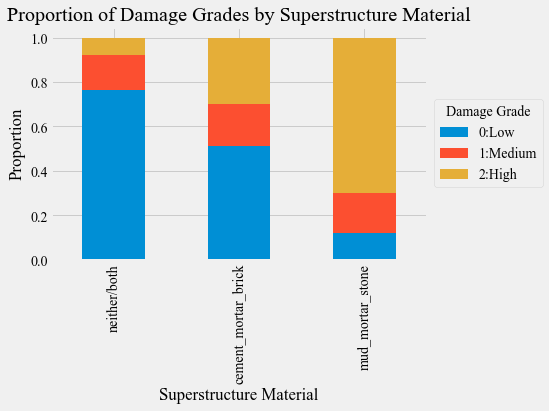

In [57]:
make_plots('Superstructure Material', 'superstructure', 'feature_engineering/superstructure')
plt.xticks(ticks=[0,1,2], labels=['neither/both', 'cement_mortar_brick', 'mud_mortar_stone'], rotation='vertical')
plt.savefig('figures/feature_engineering/superstructure.png', bbox_inches = 'tight', transparent = True)

# 2) Creating Data Files <a class="anchor" id="creating_data_files"></a>
[To contents](#contents)
- Drop required columns, then write them out to csv for future use
- Split up data for training and testing

## A) Dropping Columns <a class="anchor" id="dropping_columns"></a>
[To contents](#contents)

- Drop columns with data collected post-earthquake and geography
- Keep `damage_grade` since it is the feature to be predicted

In [58]:
building.drop('district_name', axis=1, inplace=True)
building.drop('technical_solution_proposed', axis=1, inplace=True)
building.drop('count_floors_post_eq', axis=1, inplace=True)
building.drop('height_ft_post_eq', axis=1, inplace=True)
building.drop('building_id', axis=1, inplace=True)
building.drop('condition_post_eq', axis=1, inplace=True)

In [59]:
# what our data looks like currently
print(building.shape)
building.head()

(762094, 29)


,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade,num_reinforced_concrete,reinforced_concrete,superstructure
0,12,1207,120703,1.0,9.0,288.0,9.0,0,4,1,2,3,0,6,0,1,0,0,0,0,0,1,0,0,0,1,0,0,2
1,12,1207,120703,1.0,15.0,364.0,9.0,0,4,1,2,3,0,6,0,1,0,0,0,0,0,1,0,0,0,2,0,0,2
2,12,1207,120703,1.0,20.0,384.0,9.0,0,4,1,2,3,0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
3,12,1207,120703,1.0,20.0,312.0,9.0,0,4,1,2,3,0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
4,12,1207,120703,1.0,30.0,308.0,9.0,0,4,1,2,3,0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2


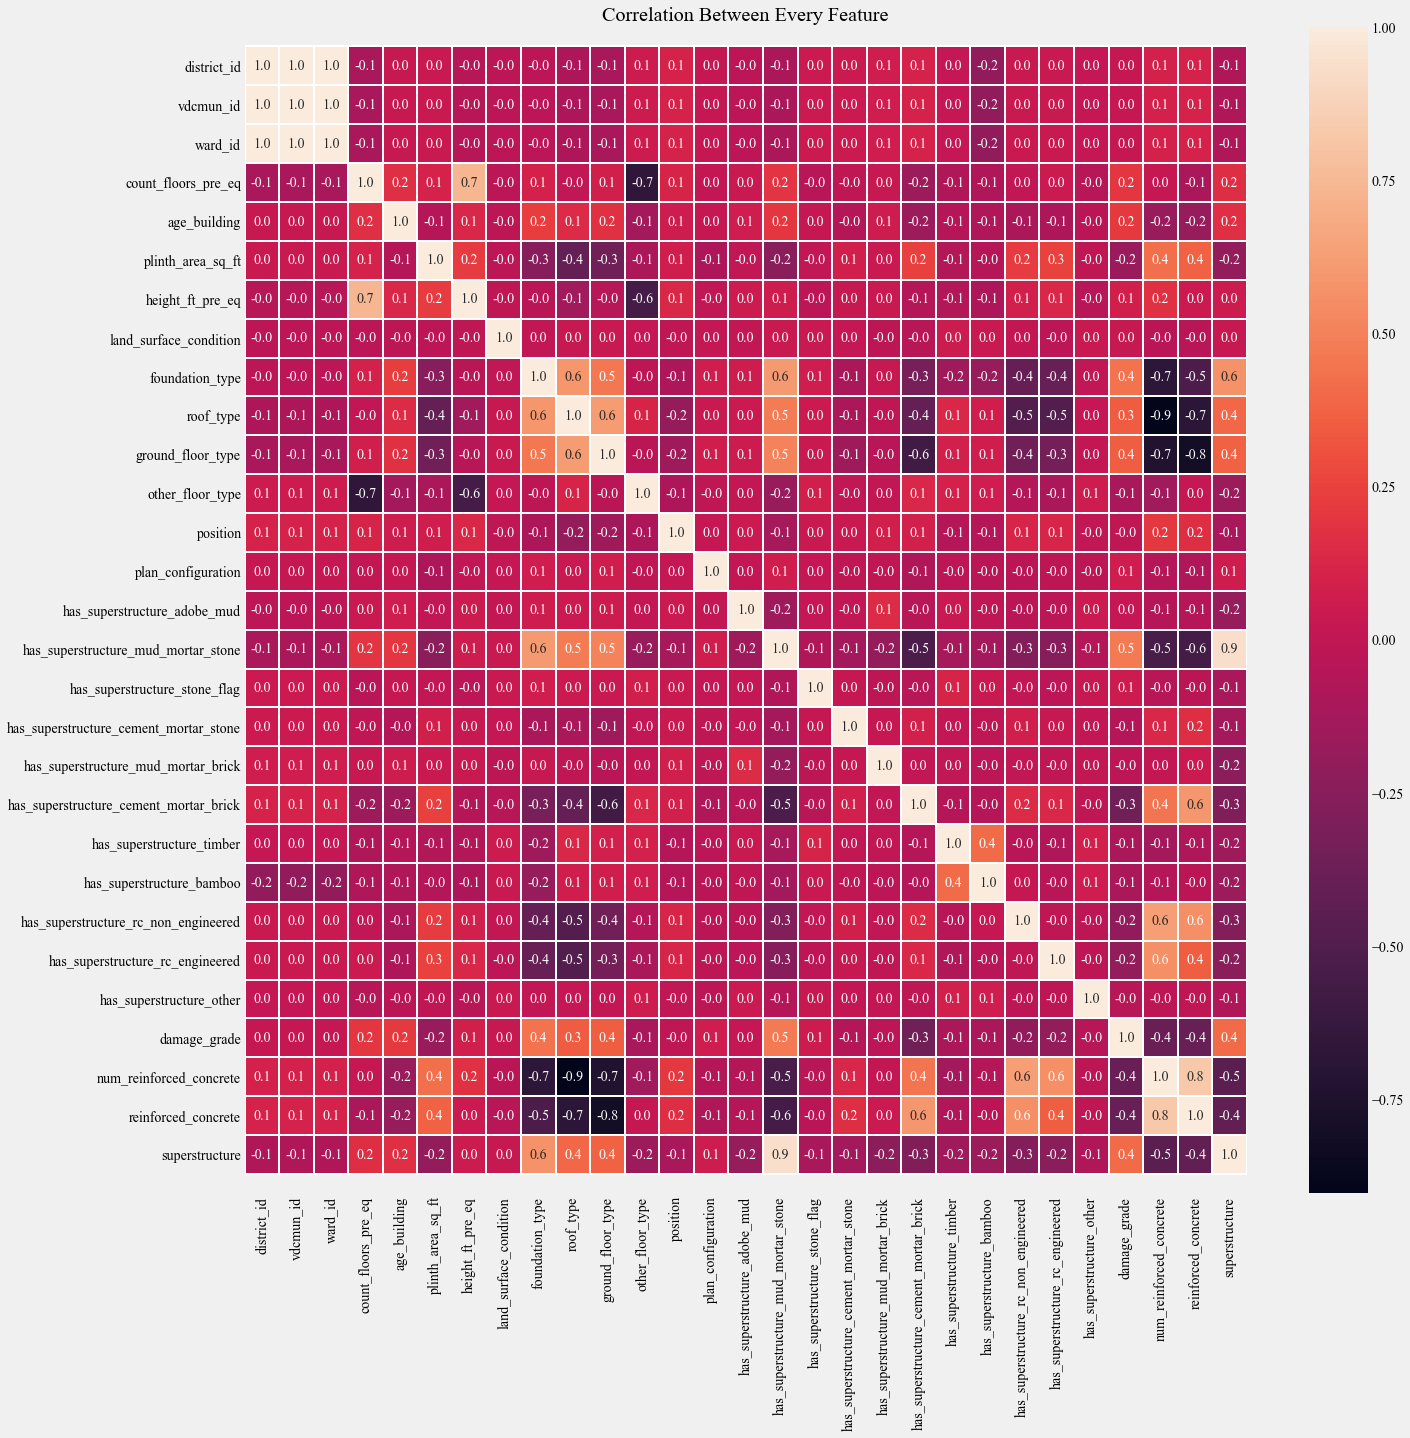

In [60]:
corr_matrix = building.corr()
feature = corr_matrix.index
plt.figure(figsize = (20, 20))
plt.title('Correlation Between Every Feature')
graph = sns.heatmap(corr_matrix, linewidths = 0.1, annot = True, fmt='.1f')
bottom, top = graph.get_ylim()
graph.set_ylim(bottom + 0.5, top - 0.5)
corr_target_row = corr_matrix['damage_grade']

plt.savefig('figures/models/correlation_matrix_all.png', bbox_inches = 'tight', transparent = True)

## B) Scaling <a class="anchor" id="scaling"></a>
[To contents](#contents)
- Convert data from raw numbers to z-score (how many standard deviations above the mean)
- K-Nearest-Neighbors and Neural Network perform better with standardized data
- Random Forest performs the same with original and standardized data

In [61]:
def standard_units(x):
    return (x - np.average(x))/np.std(x,ddof=1)

for col in building.columns:
    if col != 'damage_grade':
        building[col] = standard_units(building[col])

In [62]:
# what our data looks like currently
building.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade,num_reinforced_concrete,reinforced_concrete,superstructure
0,-2.370684,-2.367098,-2.367137,-1.69239,-0.672850,-0.581098,-1.414837,-0.427257,1.660964,0.249273,0.424942,1.956561,-0.476026,0.042765,-0.210426,0.49958,-0.190788,-0.126767,-0.153301,-0.277555,-0.590854,3.380073,-0.203577,-0.129071,-0.110329,1,-0.29955,-0.362767,0.482047
1,-2.370684,-2.367098,-2.367137,-1.69239,-0.320270,-0.193897,-1.414837,-0.427257,1.660964,0.249273,0.424942,1.956561,-0.476026,0.042765,-0.210426,0.49958,-0.190788,-0.126767,-0.153301,-0.277555,-0.590854,3.380073,-0.203577,-0.129071,-0.110329,2,-0.29955,-0.362767,0.482047
2,-2.370684,-2.367098,-2.367137,-1.69239,-0.026454,-0.092002,-1.414837,-0.427257,1.660964,0.249273,0.424942,1.956561,-0.476026,0.042765,-0.210426,0.49958,-0.190788,-0.126767,-0.153301,-0.277555,-0.590854,-0.295851,-0.203577,-0.129071,-0.110329,0,-0.29955,-0.362767,0.482047
3,-2.370684,-2.367098,-2.367137,-1.69239,-0.026454,-0.458824,-1.414837,-0.427257,1.660964,0.249273,0.424942,1.956561,-0.476026,0.042765,-0.210426,0.49958,-0.190788,-0.126767,-0.153301,-0.277555,-0.590854,-0.295851,-0.203577,-0.129071,-0.110329,0,-0.29955,-0.362767,0.482047
4,-2.370684,-2.367098,-2.367137,-1.69239,0.561179,-0.479203,-1.414837,-0.427257,1.660964,0.249273,0.424942,1.956561,-0.476026,0.042765,-0.210426,0.49958,-0.190788,-0.126767,-0.153301,-0.277555,-0.590854,-0.295851,-0.203577,-0.129071,-0.110329,0,-0.29955,-0.362767,0.482047


## C) Splitting Up Data <a class="anchor" id="splitting_up_data"></a>
[To contents](#contents)
- Split the training data up into the following segments:
     - Training Data: 70%
     - Test Data: 30%

In [63]:
# full data
features = building.drop(columns='damage_grade')
labels = building['damage_grade']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# check sizes
for dataset in [y_train, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.7
0.3


In [64]:
# write out split data
X_train.to_csv('data/split/train_features.csv', index=False)
X_test.to_csv('data/split/test_features.csv', index=False)

y_train.to_csv('data/split/train_labels.csv', index=False)
y_test.to_csv('data/split/test_labels.csv', index=False)

# 3) Regression Model<a class="anchor" id="regression_model"></a>
[To contents](#contents)

- K-Fold Cross-Validation shows the accuracy of the model when training on different subsets of the data
    - Split training data into K subsets
    - Iterate through the dataset K times, each time putting a different subset aside for validation and using the other K-1 for training

### K-Fold Cross Validation
Source: https://scikit-learn.org/stable/modules/cross_validation.html
<img src="figures/models/cross_validation.png" alt="cross_validation" width="400"/>

## A) Data Preparation<a class="anchor" id="data_preparation"></a>
[To contents](#contents)

In [65]:
EN_reg_df = pd.read_csv('data/csv_building_structure.csv')

# checking for missing values
sum(EN_reg_df.isnull().any(axis=1)) # there are 12 rows with missing values
# note that this is small enough such that the rows with missing values can be removed:
EN_reg_df = EN_reg_df.dropna(axis=0)
EN_reg_df.isnull().values.any() # no missing values!

False

In [66]:
# converting damage grade to categorical label
EN_reg_df["damage_grade"]=EN_reg_df['damage_grade'].map({'Grade 5':5,'Grade 4':4,'Grade 3':3, 'Grade 2':2, 'Grade 1':1})

# removing building_id, district_id, municip_id, and ward_id since not relevant to structural information:
columns_to_drop = ['other_floor_type', 'building_id', 'district_id', 'vdcmun_id', 'ward_id']
EN_reg_df.drop(columns=columns_to_drop, axis = 1, inplace = True)

In [67]:
# create indicator variables
land_surface_condition_dummies = pd.get_dummies(EN_reg_df['land_surface_condition'].astype('category'))
foundation_type_dummies = pd.get_dummies(EN_reg_df['foundation_type'].astype('category'))
roof_type_dummies = pd.get_dummies(EN_reg_df['roof_type'].astype('category'))
ground_floor_type_dummies = pd.get_dummies(EN_reg_df['ground_floor_type'].astype('category'))
position_dummies = pd.get_dummies(EN_reg_df['position'].astype('category'))
plan_configuration_dummies = pd.get_dummies(EN_reg_df['plan_configuration'].astype('category'))
condition_post_eq_dummies = pd.get_dummies(EN_reg_df['condition_post_eq'].astype('category'))
technical_solution_proposed_dummies = pd.get_dummies(EN_reg_df['technical_solution_proposed'].astype('category'))

# merging dummies with existing data frame
EN_reg_df = pd.merge(EN_reg_df, land_surface_condition_dummies, left_index = True, right_index = True)
EN_reg_df = pd.merge(EN_reg_df, foundation_type_dummies, left_index = True, right_index = True)
EN_reg_df = pd.merge(EN_reg_df, roof_type_dummies, left_index = True, right_index = True)
EN_reg_df = pd.merge(EN_reg_df, ground_floor_type_dummies, left_index = True, right_index = True)
EN_reg_df = pd.merge(EN_reg_df, position_dummies, left_index = True, right_index = True)
EN_reg_df = pd.merge(EN_reg_df, plan_configuration_dummies, left_index = True, right_index = True)
EN_reg_df = pd.merge(EN_reg_df, condition_post_eq_dummies, left_index = True, right_index = True)
EN_reg_df = pd.merge(EN_reg_df, technical_solution_proposed_dummies, left_index = True, right_index = True)


# dropping the original columns that generated the dummies
columns_to_drop = ['land_surface_condition','foundation_type','roof_type','ground_floor_type','position',
                   'plan_configuration','condition_post_eq','technical_solution_proposed']
EN_reg_df.drop(columns_to_drop, axis = 1, inplace = True) 

In [68]:
# standardizing 'plinth area'
def zeroOne_scale(x):
    "Convert any array of numbers to standard units."
    return ((x - np.average(x))/np.std(x,ddof=1)+1)

EN_reg_df['plinth_area_sq_ft'] = zeroOne_scale(EN_reg_df['plinth_area_sq_ft'].values)

## B) Multiple Linear Regression with EN Regularization<a class="anchor" id="multiple_linear_regression"></a>
[To contents](#contents)

In [69]:
features = EN_reg_df.drop(columns='damage_grade')
labels = EN_reg_df['damage_grade']
X_train_EN, X_test_EN, y_train_EN, y_test_EN = train_test_split(features, labels, test_size=0.2, random_state=42)

# check sizes
for dataset in [y_train_EN, y_test_EN]:
    print(round(len(dataset) / len(labels), 2))

0.8
0.2


In [70]:
regr = ElasticNetCV(cv=10, random_state=0)
regr.fit(X_train_EN, y_train_EN.values.ravel())
         
# recording the locations of columns with nonzero data values
locations_nonzero = np.where(regr.coef_ != 0)[0].tolist() 

# visually recording which variables are used at these locations:
EN_reg_df.iloc[:,locations_nonzero].head()

,count_floors_pre_eq,count_floors_post_eq,age_building,height_ft_pre_eq,height_ft_post_eq,has_superstructure_mud_mortar_stone,Other_y,Damaged-Not used,Damaged-Repaired and used,Damaged-Rubble Clear-New building built,Damaged-Rubble clear,Damaged-Used in risk,Not damaged,Major repair,Minor repair,No need
0,1,1,9,9,9,1,0,0,0,0,0,1,0,1,0,0
1,1,1,15,9,9,1,0,0,1,0,0,0,0,0,0,0
2,1,1,20,9,9,1,0,0,1,0,0,0,0,0,1,0
3,1,1,20,9,9,1,0,0,1,0,0,0,0,0,1,0
4,1,1,30,9,9,1,0,0,1,0,0,0,0,0,1,0


## C) Model Performance<a class="anchor" id="model_performance"></a>
[To contents](#contents)

In [135]:
print('Last 5 lists MSE values for each iteration ("fold") of cross validation, adjusted alpha and lambda values:')
print('')
print(regr.mse_path_[-5:])
print('')
print('Assessing the coefficient of determination, R^2, of predictions on validation dataset:')
print('')
print(regr.score(X_test_EN, y_test_EN))

Last 5 lists MSE values for each iteration ("fold") of cross validation, adjusted alpha and lambda values:

[[0.16232867 0.16486505 0.16127006 0.16388886 0.16550377 0.16516413
  0.16558697 0.16549122 0.16485036 0.16585956]
 [0.15939953 0.1618826  0.15839114 0.161022   0.16259119 0.16211518
  0.16267494 0.16257331 0.16178433 0.16288792]
 [0.15670152 0.15913444 0.15573895 0.15838494 0.15991138 0.15930854
  0.15999341 0.15988514 0.15896482 0.16015651]
 [0.15422961 0.15661258 0.15330526 0.15595767 0.15745031 0.15673237
  0.15753243 0.1574151  0.15636908 0.15764848]
 [0.15196685 0.15430235 0.15107657 0.15373519 0.15519757 0.15437441
  0.15527921 0.15515232 0.15399164 0.15535421]]

Assessing the coefficient of determination, R^2, of predictions on validation dataset:

0.9137855468621786


# 4) Classification Models <a class="anchor" id="classification_models"></a>
[To contents](#contents)
- Use the training dataset using 5-Fold Cross-Validaiton to get a basic idea of the model's performance
- 5-Fold Cross-Validation shows the accuracy of the model when training on different subsets of the data
    - Split training data into 5 subsets
    - Iterate through the dataset 5 times, each time putting a different subset aside for validation and using the other 4 for training
- Use test set to select final model
- Accuracy = (true positive + true negative)/total
- Precision = true positive/(true positive + false positive)
- Recall = true positive/(true positive + false negative)

In [72]:
# read in data
X_train = pd.read_csv('data/split/train_features.csv')
X_test = pd.read_csv('data/split/test_features.csv')

y_train = pd.read_csv('data/split/train_labels.csv')
y_test = pd.read_csv('data/split/test_labels.csv')

In [73]:
# prints results of GridSearchCV
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        # prints mean and 2 standard deviations to each side
        print('{} (+/-{}) parameters: {}'.format(round(mean, 3), round(std * 2, 3), params))

In [221]:
# evaluates prediction time, accuracy, precision, recall
def evaluate_model(name, model, features, labels):
    pred = model.predict(features)
    accuracy = 0
    precision = 0
    recall = 0
    accuracy = max(accuracy, round(accuracy_score(labels, pred), 4))
    precision = max(precision, round(precision_score(labels, pred, average='weighted'), 4))
    recall = max(recall, round(recall_score(labels, pred, average='weighted'), 4))
    print('{}'.format(name))
    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))

## A) Random Forest<a class="anchor" id="random_forest"></a>
[To contents](#contents)
- Random Forest randomly selects features for each decision tree, so computation varies less with feature increase since
- Only remove features that we already accounted for through engineering, namely, the `has_superstructure` features

In [180]:
# modify train and test sets
columns_to_drop = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 
                   'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
                   'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 
                   'has_superstructure_timber', 'has_superstructure_bamboo', 
                   'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 
                   'has_superstructure_other']
X_train_rf = X_train.drop(columns=columns_to_drop)
X_test_rf = X_test.drop(columns=columns_to_drop)

In [181]:
# view parameters
print(RandomForestClassifier())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [182]:
# fit model
rf = RandomForestClassifier()
parameters = {
    'max_depth': [12, 16, 20],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [20, 30]
}

cv1 = GridSearchCV(rf, parameters, cv=5)
cv1.fit(X_train_rf, y_train.values.ravel())

print_results(cv1)

BEST PARAMS: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 30}

0.728 (+/-0.001) parameters: {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 20}
0.729 (+/-0.001) parameters: {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 30}
0.729 (+/-0.002) parameters: {'max_depth': 12, 'max_features': 'log2', 'n_estimators': 20}
0.729 (+/-0.001) parameters: {'max_depth': 12, 'max_features': 'log2', 'n_estimators': 30}
0.74 (+/-0.002) parameters: {'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 20}
0.741 (+/-0.001) parameters: {'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 30}
0.74 (+/-0.001) parameters: {'max_depth': 16, 'max_features': 'log2', 'n_estimators': 20}
0.74 (+/-0.002) parameters: {'max_depth': 16, 'max_features': 'log2', 'n_estimators': 30}
0.745 (+/-0.002) parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 20}
0.746 (+/-0.001) parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 30}
0.745 (+/-0.001) 

In [183]:
# evaluate on test data
random_forest = cv1.best_estimator_
evaluate_model('Random Forest', random_forest, X_test_rf, y_test)

Random Forest
Accuracy: 0.7476
Precision: 0.7176
Recall: 0.7476


In [184]:
# save model
joblib.dump(random_forest, 'models/random_forest.pkl')

['models/random_forest.pkl']

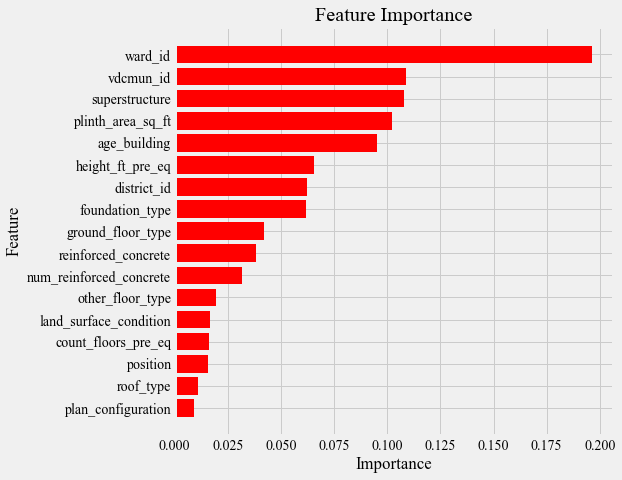

In [185]:
# generate feature importance plot
feat_imp = random_forest.feature_importances_
indices = np.argsort(feat_imp)
plt.figure(figsize=(7, 7))
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(range(len(indices)), [X_train_rf.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center');
plt.savefig('figures/models/random_forest_feature_importance.png', bbox_inches = 'tight', transparent = True)

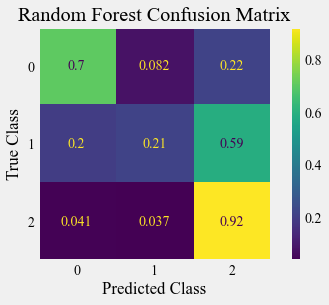

In [186]:
# confusion matrix of results
classes = ['0', '1', '2']
disp = plot_confusion_matrix(random_forest, X_test_rf, y_test, display_labels = classes,
                             cmap = 'viridis', normalize = 'true')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.grid(False);
plt.savefig('figures/models/random_forest_confusion_matrix.png', bbox_inches = 'tight', transparent = True)

## B) K-Nearest Neighbors<a class="anchor" id="knn"></a>
[To contents](#contents)
- Curse of dimensionality means K-Nearest-Neighbors favors lower dimensional data
- K-Nearest-Neighbors is also computationally intensive
- Select 4 features based on data exploration, [Multiple Linear Regression Model](#regression_model), [Correlation Matrix](#dropping_columns) and feature importance plot in [Random Forest Model](#random_forest)
    - Choose final features based on correlation and impact of features
    - Eliminate features that have high correlation with each other
    - Do not use location indicators: these are randomly numbered and will not produce 3 clusters well

In [210]:
# final columns to keep for k-nearest-neighbors
columns_to_keep = ['damage_grade','plinth_area_sq_ft','height_ft_pre_eq','superstructure','age_building']
building_reduced = building[columns_to_keep]

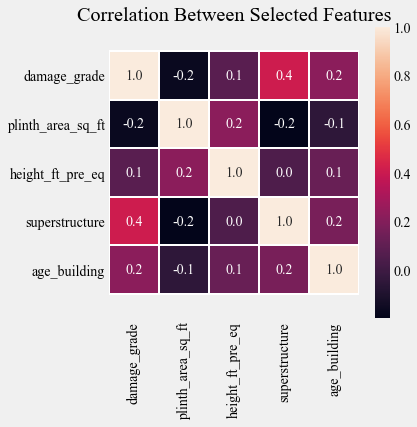

In [211]:
# generate correlation matrix heat map
corr_matrix = building_reduced.corr()
feature = corr_matrix.index
plt.figure(figsize = (5, 5))
plt.title('Correlation Between Selected Features')
graph = sns.heatmap(corr_matrix, linewidths = 0.1, annot = True, fmt='.1f')
bottom, top = graph.get_ylim()
graph.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('figures/models/knn_correlation_matrix.png', bbox_inches = 'tight', transparent = True)
corr_target_row = corr_matrix['damage_grade']

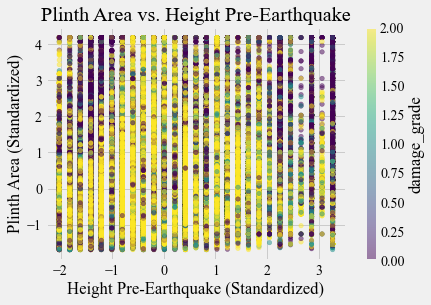

In [212]:
# scatterplot of the two continuous features we chose
building.plot.scatter('height_ft_pre_eq', 'plinth_area_sq_ft', c='damage_grade', colormap='viridis',
                      title='Plinth Area vs. Height Pre-Earthquake', xlabel='Height Pre-Earthquake (Standardized)',
                      ylabel='Plinth Area (Standardized)', alpha = 0.5);
plt.savefig('figures/models/knn_area_vs_age.png', bbox_inches = 'tight', transparent = True)

In [213]:
# modify train and test sets
columns_to_keep = ['plinth_area_sq_ft','height_ft_pre_eq','superstructure','age_building']
X_train_knn = X_train[columns_to_keep]
X_test_knn = X_test[columns_to_keep]

In [214]:
# view parameters
print(KNeighborsClassifier())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [215]:
# fit model
knn = KNeighborsClassifier()
parameters = {
    'n_neighbors': [20, 50, 100]
}

cv2 = GridSearchCV(knn, parameters, cv=5)
cv2.fit(X_train_knn, y_train.values.ravel())

print_results(cv2)

BEST PARAMS: {'n_neighbors': 100}

0.681 (+/-0.003) parameters: {'n_neighbors': 20}
0.687 (+/-0.002) parameters: {'n_neighbors': 50}
0.687 (+/-0.002) parameters: {'n_neighbors': 100}


In [222]:
# evaluate on test data
knn = cv2.best_estimator_
evaluate_model('K-Nearest-Neighbors', knn, X_test_knn, y_test)

K-Nearest-Neighbors
Accuracy: 0.688
Precision: 0.6222
Recall: 0.688


In [223]:
# save model
joblib.dump(knn, 'models/knn.pkl')

['models/knn.pkl']

## C) Neural Network<a class="anchor" id="neural_network"></a>
[To contents](#contents)
- Neural Network chooses features in the model, so keep all features for this model
- Choose number of hidden layers and hidden neurons per layer
    - Avoid overfitting and underfitting
    - Hidden layers: 2
    - Neurons per layer: $(\frac{2}{3}*N_i) + N_o$

In [169]:
# one hot encoding to transform class values (ex. 1 becomes [0, 1, 0])
from keras.utils import np_utils
y_train_nn = np_utils.to_categorical(y_train)
y_test_nn = np_utils.to_categorical(y_test)
nclasses = y_test_nn.shape[1]

In [170]:
# choose number of hidden neurons
round(len(X_train.columns)*2/3 + 3)

22

In [171]:
model = keras.Sequential()

# add input layer, 2 hidden layers, and output layer
model.add(Dense(22, input_dim=len(X_train.columns), kernel_initializer='normal', activation='relu'))
model.add(Dense(22, kernel_initializer='normal', activation='relu'))
model.add(Dense(nclasses, activation='softmax'))

In [172]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 22)                638       
                                                                 
 dense_17 (Dense)            (None, 22)                506       
                                                                 
 dense_18 (Dense)            (None, 3)                 69        
                                                                 
Total params: 1,213
Trainable params: 1,213
Non-trainable params: 0
_________________________________________________________________


In [173]:
# compile, fit, evaluate
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])
model.fit(X_train, y_train_nn, epochs=10, batch_size=1000, verbose=1)
model.evaluate(X_test, y_test_nn)

Epoch 1/10
534/534 [==============================] - 2s 1ms/step - loss: 0.7782 - accuracy: 0.6986 - recall_9: 0.6115 - precision_9: 0.7337
Epoch 2/10
534/534 [==============================] - 1s 1ms/step - loss: 0.7398 - accuracy: 0.7047 - recall_9: 0.6594 - precision_9: 0.7404
Epoch 3/10
534/534 [==============================] - 1s 1ms/step - loss: 0.7298 - accuracy: 0.7065 - recall_9: 0.6562 - precision_9: 0.7475
Epoch 4/10
534/534 [==============================] - 1s 1ms/step - loss: 0.7231 - accuracy: 0.7080 - recall_9: 0.6505 - precision_9: 0.7550
Epoch 5/10
534/534 [==============================] - 1s 1ms/step - loss: 0.7185 - accuracy: 0.7089 - recall_9: 0.6473 - precision_9: 0.7591
Epoch 6/10
534/534 [==============================] - 1s 1ms/step - loss: 0.7148 - accuracy: 0.7091 - recall_9: 0.6461 - precision_9: 0.7612
Epoch 7/10
534/534 [==============================] - 1s 1ms/step - loss: 0.7110 - accuracy: 0.7098 - recall_9: 0.6448 - precision_9: 0.7627
Epoch 8/10
53

[0.7028148770332336,
 0.7104304432868958,
 0.6406930088996887,
 0.7630729079246521]

In [174]:
# save model
joblib.dump(model, 'models/neural_network.pkl')

INFO:tensorflow:Assets written to: ram://e554ee62-5a7d-44bb-8ac6-4d17ea8f323f/assets


['models/neural_network.pkl']

# 5) Results<a class="anchor" id="results"></a>
[To contents](#contents)

### Multiple Linear Regression with EN Regularization
- $R^2$: 0.914

### Classification Models
- Random Forest
    - Accuracy: 0.748
    - Precision (weighted): 0.718
    - Recall (weighted): 0.748
- K-Nearest-Neighbors
    - Accuracy: 0.688
    - Precision (weighted): 0.622
    - Recall (weighted): 0.688
- Neural Network
    - Accuracy: 0.710
    - Precision (weighted): 0.641
    - Recall (weighted): 0.763

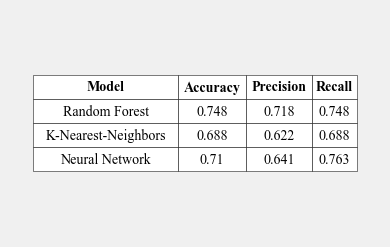

In [227]:
results_df = pd.DataFrame({'Model': ['Random Forest', 'K-Nearest-Neighbors', 'Neural Network'],
                           'Accuracy': [0.748, 0.688, 0.710],
                           'Precision': [0.718, 0.622, 0.641],
                           'Recall': [0.748, 0.688, 0.763]})
results_table = plt.table(cellText = results_df.values, colLabels = results_df.columns, loc='center', cellLoc='center')
results_table.auto_set_column_width(col=list(range(len(results_df.columns))))
results_table.scale(1, 2)
# bold column headings
for (row, col), cell in results_table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
plt.axis('off');
plt.savefig('figures/models/results.png', bbox_inches = 'tight', transparent = True)

### Precision and Recall
Source: https://towardsdatascience.com/whats-the-deal-with-accuracy-precision-recall-and-f1-f5d8b4db1021
<img src="figures/models/precision_recall.png" alt="precision_recall" width="600"/>